In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
#----------------------------------------------------------------------
# Densidad superficial de masa con bines equiespaciados (en x o y)
#----------------------------------------------------------------------
def surf_density_x(x,y,m,nbin,nmin,nmax):
    
    
    mass, xedges, yedges = np.histogram2d(x, y, nbin, [[nmin,nmax],[nmin,nmax]], density=False, weights=m)
    
#     nodos  = np.concatenate([-nodos_[::-1],nodos_])
    
    sigmax = np.zeros(nbin)
    sigmay = np.zeros(nbin)
    
    widthx = np.diff(xedges)
    widthy = np.diff(yedges)
    
    medx   = xedges[:-1] + widthx/2.
    medy   = yedges[:-1] + widthy/2.
    
    middle = nbin//2
    
    for i in range(nbin):
        areax     = widthx[i]*widthy[middle]
        sigmax[i] = mass[i,middle]/areax

        areay     = widthy[i]*widthx[middle]
        sigmay[i] = mass[middle,i]/areay
    
    return sigmax, sigmay, medx, medy

### Lbar GADGET a z=0

In [4]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/data/alejandro/is2/ornella/'

# for isnap in snapshot:

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'lbar_set_GD.dat','a')
       

isnap=496

snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

halos = (0,1,3)

for i in halos:
    
    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

    #paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    #paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3.*aexp[isnap])
    corte2, = np.where(r<6.*aexp[isnap])

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax,phimed = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)
    #     A2_2, phi, rbin2 = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)
    
    print('phimed=', phimed)
    #---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp[isnap],1000)

    hbar  = 0.15
    resta = finterp(point) - hbar


    mask, = np.where(resta < 0.)

    lbar1 = point[mask][0]

    print 'lbar_0.15 = ', lbar1
#---lbar2---------------------------------------------------------------------------------

    phi_int = sint.interp1d(rbin,phi,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp[isnap],1000)

    rest = np.abs(phi_int(point)-phimax)
    
#     angulo = 0.087
    angulo = 0.3
    limit, = np.where(rest>np.arcsin(angulo))

    lbar2 = point[limit][0]

    print 'lbar_phi = ', lbar2
    
    angulo2 = 0.035
    limit2, = np.where(rest>np.arcsin(angulo2))

    lbar5 = point[limit2][0]

    print 'lbar_phi_mod = ', lbar5

#---lbar 3 ----------------------------------------------------------------------
    finterp1 = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point1 = np.linspace(rmax,6*aexp[isnap],1000)

    hbar1 = 0.25*A2max
    print 'hbar1 = ', hbar1
    resta1 = finterp1(point) - hbar1

    mask1, = np.where(resta1 < 0.)

    lbar3 = point1[mask1][0]
    
    print 'lbar_0.25 = ', lbar3
    
#---lbar 4 ----------------------------------------------------------------------
    xx = xn*np.cos(phimax)  + yn*np.sin(phimax)
    yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
    zz = zn
    
    R = np.sqrt(xx**2 + yy**2)
    
    corte0, = np.where(r<rgal)

    nbin = 51
    R_profile, medR = density.surf_density2(R[corte0], mstr[corte0]*1e10,nbin,0,5)
    sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0]*1e10,nbin,-5,5)
    
    finterp_sx = sint.interp1d(sigmax,medx,fill_value="extrapolate")
    finterp_sy = sint.interp1d(sigmay,medy,fill_value="extrapolate")
    point = np.linspace(-5,5,301)

    SX = finterp_sx(point)
    SY = finterp_sy(point)
    
    mask1, = np.where(point>0)
    mask2, = np.where(point<0)
    PROM_SX = (SX[mask1] + SX[mask2][::-1]) / 2
    PROM_SY = (SY[mask1] + SY[mask2][::-1]) / 2
    diff3 = 10**PROM_SX-10**PROM_SY

    finterp = sint.interp1d(point[mask1],diff3,fill_value="extrapolate")
    point2 = np.linspace(point[mask1][diff3.argmax()],5,200)
    print (point[mask1][diff3.argmax()])
    corte = diff3.max()*0.05
#     print(str('%1.3e'%corte), corte)

    resta = finterp(point2) - corte
    mask, = np.where(resta < 0.)
    lbar4 = point2[mask][0]

    print 'lbar_perf = ', lbar4


    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

    ax[0].plot(rbin,A2)
    ax[0].axvline(x=lbar1,color='r', label='$L_{bar}$ en 0.15')
    ax[0].axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
    ax[0].axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
    ax[0].axvline(x=lbar5,color='g',label='$L_{bar}$ usando $\phi(R)$ mod', ls='--')
    ax[0].axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
    ax[0].axhline(y=hbar1,color='k',ls='--',label='0.25*$A_2^{max}$')
    ax[0].axhline(y=0.15,color='k',ls=':',label='0.15')
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=15)
    ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[0].set_ylabel('$A_{2}(R)$',fontsize=15)
    ax[0].set_xlim(0,5)
    ax[0].legend(fontsize=15,frameon=False)

    line1 = + np.arcsin(angulo)
    line2 = - np.arcsin(angulo)
    
    line1_ = + np.arcsin(angulo2)
    line2_ = - np.arcsin(angulo2)
    ax[1].plot(rbin,phi-phimed)
    ax[1].axvline(x=lbar1,color='r')
    ax[1].axvline(x=lbar3,color='b')
    ax[1].fill_between(rbin,line2,line1,color='k',alpha=0.3)
    ax[1].fill_between(rbin,line2_,line1_,color='red',alpha=0.3)
    ax[1].axvline(x=lbar2,color='g')
    ax[1].axvline(x=lbar5,color='g',ls='--')
    ax[1].axvline(x=lbar4,color='darkorange')
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=15)
    ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[1].set_ylabel('$\phi(R)$',fontsize=15)
    ax[1].set_xlabel('R [kpc]',fontsize=15)
    
    plt.show()
    
#     archivo.write(str('%s'%i) +'\t'+
#                    str('%12.8f'% lbar1) +'\t'+
#                    str('%12.8f'% lbar2) +'\t'+
#                    str('%12.8f'% lbar3) +'\t'+
#                    str('%12.8f'% lbar4) +'\n')
# archivo.close()
    


IOError: Unable to open file (unable to open file: name = '/mnt/data/alejandro/is2/ornella/outputs_1/snap_496.h5py', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

('phimed=', 0.0028417275287210943)
lbar_0.15 =  0.8912719403914042
lbar_phi =  1.3610227872432954
lbar_phi_mod =  0.8877700703935734
hbar1 =  0.10617148650113588
lbar_0.25 =  0.9207877018016934
lbar_perf =  1.2168691330228412
lbar_perf_mod =  1.0709953509373107


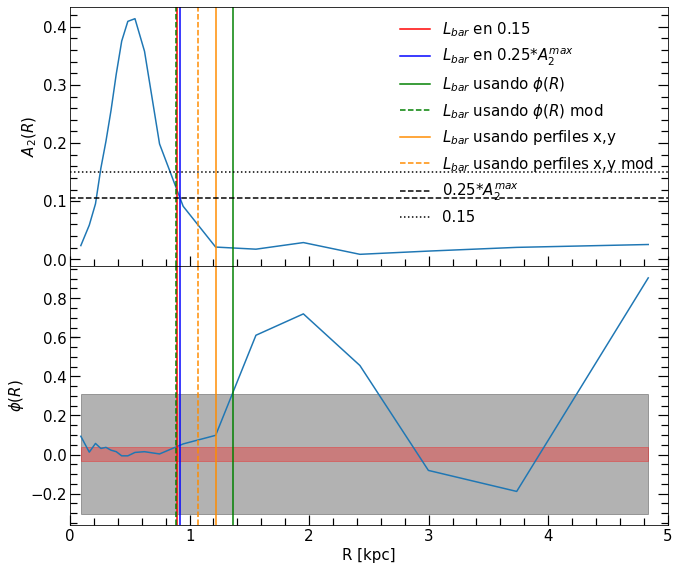

('phimed=', -0.9361826181411743)
lbar_0.15 =  1.336786551921767
lbar_phi =  3.117249859027963
lbar_phi_mod =  1.8299148723730898
hbar1 =  0.11723678151284915
lbar_0.25 =  1.439313231123107
lbar_perf =  3.166260243255557
lbar_perf_mod =  1.8676435921898857


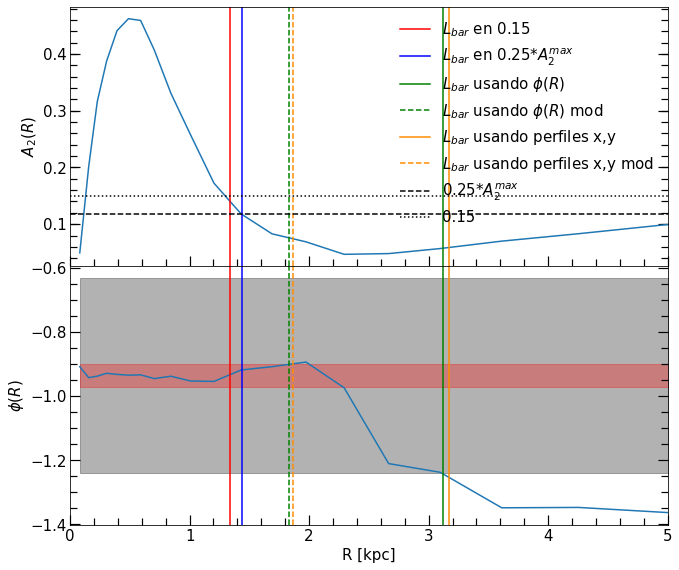

('phimed=', 0.17481132596731186)
lbar_0.15 =  0.519289493560791
lbar_phi =  2.653420011115943
lbar_phi_mod =  0.6070686408124168
hbar1 =  0.018838115013791453
lbar_0.25 =  2.4010549627675184
lbar_perf =  0.7342791830641704
lbar_perf_mod =  0.18145259916687895


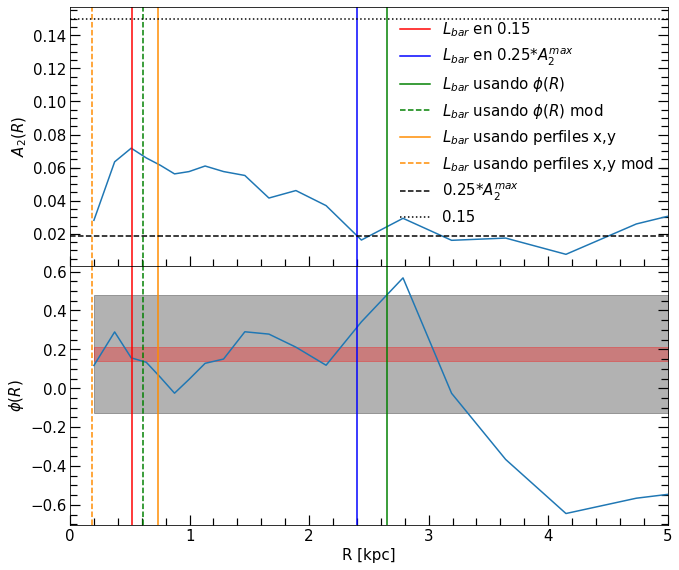

In [22]:
import h5py
import rotation_mio as rot
import barstrength2 as strng
import scipy.interpolate as sint
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]


path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'lbar_set_GS.dat','a')


# for j in range(len(snapshot)-1,32,-1):
j=0
#     path = '/home/ornela/SimCLUES/'



halos = (1,2,4)

for i in halos:  
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    #-----------------------------------------------------------------------------------

    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.*aexp)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax,phimed = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    print('phimed=', phimed)
    #---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp,100)

    hbar  = 0.15
    resta = finterp(point) - hbar

    mask, = np.where(resta < 0.)

    lbar1 = point[mask][0]

    print 'lbar_0.15 = ', lbar1
    # #---lbar2---------------------------------------------------------------------------------

    phi_int = sint.interp1d(rbin,phi,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp,1000)

#     angulo=0.087
    angulo=0.3
    rest = np.abs(phi_int(point)-phimed)
    limit, = np.where(rest>np.arcsin(angulo))

    lbar2 = point[limit][0]

    print 'lbar_phi = ', lbar2
    
    angulo2 = 0.035
    limit2, = np.where(rest>np.arcsin(angulo2))

    lbar5 = point[limit2][0]

    print 'lbar_phi_mod = ', lbar5

    #---lbar 3 ----------------------------------------------------------------------
    finterp1 = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point1 = np.linspace(rmax,6*aexp,1000)

    hbar1 = 0.25*A2max
    print 'hbar1 = ', hbar1
    resta1 = finterp1(point) - hbar1

    mask1, = np.where(resta1 < 0.)

    lbar3 = point1[mask1][0]
    
    print 'lbar_0.25 = ', lbar3
    
    #---lbar 4 ----------------------------------------------------------------------
    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn
    
    R = np.sqrt(xx**2 + yy**2)
    
    corte0, = np.where(r<rgal)

    nbin = 51
    R_profile, medR = density.surf_density2(R[corte0], mstr[corte0],nbin,0,5)
    sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0],nbin,-5,5)


    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    arg = diff.argmax()

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),8,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf = ', lbar4
    
    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6
    

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

    ax[0].plot(rbin,A2)
    ax[0].axvline(x=lbar1,color='r', label='$L_{bar}$ en 0.15')
    ax[0].axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
    ax[0].axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
    ax[0].axvline(x=lbar5,color='g',label='$L_{bar}$ usando $\phi(R)$ mod', ls='--')
    ax[0].axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
    ax[0].axvline(x=lbar6,color='darkorange',label='$L_{bar}$ usando perfiles x,y mod', ls='--')
    ax[0].axhline(y=hbar1,color='k',ls='--',label='0.25*$A_2^{max}$')
    ax[0].axhline(y=0.15,color='k',ls=':',label='0.15')
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=15)
    ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[0].set_ylabel('$A_{2}(R)$',fontsize=15)
    ax[0].set_xlim(0,5)
    ax[0].legend(fontsize=15,frameon=False)

    line1 = phimed + np.arcsin(angulo)
    line2 = phimed - np.arcsin(angulo)
    
    line1_ = phimed + np.arcsin(angulo2)
    line2_ = phimed - np.arcsin(angulo2)
    ax[1].plot(rbin,phi)
    ax[1].axvline(x=lbar1,color='r')
    ax[1].axvline(x=lbar3,color='b')
    ax[1].fill_between(rbin,line2,line1,color='k',alpha=0.3)
    ax[1].fill_between(rbin,line2_,line1_,color='red',alpha=0.3)
    ax[1].axvline(x=lbar2,color='g')
    ax[1].axvline(x=lbar5,color='g',ls='--')
    ax[1].axvline(x=lbar4,color='darkorange')
    ax[1].axvline(x=lbar6,color='darkorange',ls='--')
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=15)
    ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax[1].set_ylabel('$\phi(R)$',fontsize=15)
    ax[1].set_xlabel('R [kpc]',fontsize=15)
    
    plt.show()

#     archivo.write(str('%s'%i) +'\t'+
#                    str('%12.8f'% lbar1) +'\t'+
#                    str('%12.8f'% lbar2) +'\t'+
#                    str('%12.8f'% lbar3) +'\t'+
#                    str('%12.8f'% lbar4) +'\n')
# archivo.close()

### Lbar vs time GADGET-A

In [13]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]


snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

for isnap in snapshot:
# isnap=496
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
# halos = (0,1,3)
# for i in halos:
    i=0
    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

    #paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    #paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3.*aexp[isnap])
    corte2, = np.where(r<6.*aexp[isnap])

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)
    #     A2_2, phi, rbin2 = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)

    #---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp[isnap],1000)

    hbar  = 0.15
    resta = finterp(point) - hbar


    mask, = np.where(resta < 0.)

    lbar1 = point[mask][0]

    # #---lbar2---------------------------------------------------------------------------------

    phi_int = sint.interp1d(rbin,phi,fill_value="extrapolate")
    point = np.linspace(rmax,6*aexp[isnap],1000)

    rest = np.abs(phi_int(point)-phimed)
    
#     angulo = 0.087
    angulo = 0.3
    limit, = np.where(rest>np.arcsin(angulo))
    
    if len(limit)==0:
        lbar2 = np.nan
    else:
        lbar2 = point[limit][0]
        
    angulo2 = 0.035
    limit2, = np.where(rest>np.arcsin(angulo2))

    if len(limit2) == 0:
        lbar5 = np.nan
    else:
        lbar5 = point[limit2][0]

#     print 'lbar_phi_mod = ', lbar5


    #---lbar 3 ----------------------------------------------------------------------
    finterp1 = sint.interp1d(rbin,A2,fill_value="extrapolate")
    point1 = np.linspace(rmax,6*aexp[isnap],1000)

    hbar1 = 0.25*A2max
    resta1 = finterp1(point) - hbar1

    mask1, = np.where(resta1 < 0.)
    
    if len(mask1)==0:
        lbar3= np.nan
    else:
        lbar3 = point1[mask1][0]
    
  
    #---lbar 4 ----------------------------------------------------------------------
    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn
    
    R = np.sqrt(xx**2 + yy**2)
    
    corte0, = np.where(r<rgal)

    nbin = 51
    R_profile, medR = density.surf_density2(R[corte0], mstr[corte0]*1e10,nbin,0,5)
    sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0]*1e10,nbin,-5,5)


    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    arg = diff.argmax()

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),6*aexp[isnap],100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    if len(mask)==0:
        lbar4 = np.nan
    else:
        lbar4 = point[mask][0]
    
    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

#     print 'lbar_perf_mod = ', lbar6

    archivo = open(path2 + 'lbar_time_GD3.dat','a')
    archivo.write( str('%12.8f'% time)  +'\t'+
                   str('%12.8f'% lbar1) +'\t'+
                   str('%12.8f'% lbar2) +'\t'+
                   str('%12.8f'% lbar3) +'\t'+
                   str('%12.8f'% lbar4) +'\t'+
                   str('%12.8f'% lbar5) +'\t'+
                   str('%12.8f'% lbar6) +'\n')
    archivo.close()
    
##lbar_time_GD2.dat agregamos lbar 5 y lbar 6
##lbar_time_GD3.dat modifique el threshold del lbar_phi y además ahora no tomo phimax, sino phimed

In [1]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GD3.dat')
time_M31gd  = data[:,0]
lbar1_M31gd = data[:,1]
lbar2_M31gd = data[:,2]
lbar3_M31gd = data[:,3]
lbar4_M31gd = data[:,4]
lbar5_M31gd = data[:,5]
lbar6_M31gd = data[:,6]

In [20]:
# path0 = '/home/omarioni/'
path0 = '/home/ornela/SimCLUES/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

In [21]:
eps_gd = 2*0.14*aexp[::-1]

In [22]:
print(len(eps_gd),len(time_M31gd))

(497, 196)


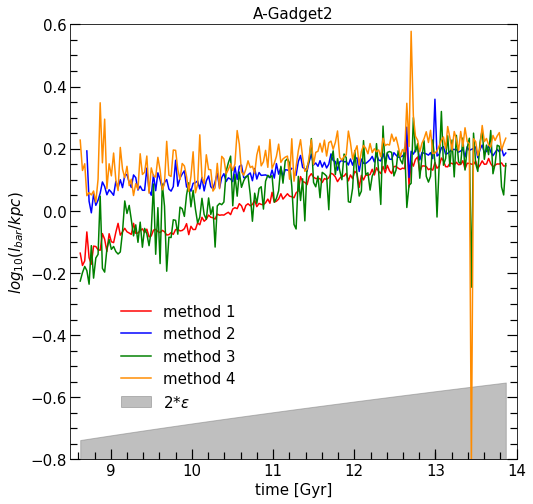

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(time_M31gd,np.log10(lbar1_M31gd), color='r', ls='-', label='method 1') #label='$L_{bar}$ at 0.15')
ax.plot(time_M31gd,np.log10(lbar3_M31gd), color='b', ls='-', label='method 2')#label='$L_{bar}$ at 0.25*$A_2^{max}$')
ax.plot(time_M31gd,np.log10(lbar5_M31gd), color='g', ls='-', label='method 3')#label='$L_{bar}$ using $\phi(R)$')
# ax.plot(time,np.log10(lbar4), color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.plot(time_M31gd,np.log10(lbar6_M31gd), color='darkorange', ls='-', label='method 4')#label='$L_{bar}$ using profiles x,y')
ax.fill_between(time_M31gd,np.log10(eps_gd[:196]),-0.9,color='grey',alpha=0.5,label='2*$\epsilon$')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$log_{10}(l_{bar}/kpc)$',fontsize=15)
ax.set_xlabel('time [Gyr]',fontsize=15)
ax.set_ylim(-0.8,0.6)
ax.set_xlim(8.5,14)
# ax.set_yscale('log')
ax.set_title('A-Gadget2',fontsize=15)
ax.legend(fontsize=15,frameon=False, loc = (0.1,0.1))
path0 = '/home/omarioni/'
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'lbar_time_allGD.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

### Lbar vs time GASOLINE

In [ ]:
import h5py
import rotation_mio as rot
import barstrength2 as strng
import scipy.interpolate as sint
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
# snapshot = snapshot[::-1]


path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

for j in range(len(snapshot)-1,32,-1):
# j=0
# path = '/home/ornela/SimCLUES/'

    halos = (1,2)
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    for i in halos:  
        

        cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
        r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
        time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
        h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
        aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

        pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
        mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
        vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

        #paso las coordenadas al centro de la galaxia
        xstr = (pstr[:,0]-cm[0])
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        r    = np.sqrt(xstr**2+ystr**2+zstr**2)

        #----------------------------------------------------------------------
        r200 = r200*aexp
        rgal = 0.15*r200          #defino el radio de la galaxia

        limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
        r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
        r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

        Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
        Mgal = Mc_str[-1]  #masa total de la galaxia

        #Calculo de los radios a 50% y 90% la masa de la galaxia
        #-----------------------------------------------------------------------
        razon = Mc_str/Mgal 
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]   #radio a 90% la masa
        r50 = r_sort[cincuenta][-1] #radio a 50% la masa

        #-----------------------------------------------------------------------

        #componentes de la velocidad del centro de masa
        veloc, = np.where(r < r50)

        vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        corte1, = np.where(r<3.*aexp)
        corte2, = np.where(r<6.*aexp)

        A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
        A2max, rmax, phimax, phimed = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)


        #---lbar 1 ----------------------------------------------------------------------
        finterp = sint.interp1d(rbin,A2,fill_value="extrapolate")
        point = np.linspace(rmax,6*aexp,100)

        hbar  = 0.15
        resta = finterp(point) - hbar

        mask, = np.where(resta < 0.)

        lbar1 = point[mask][0]

        # #---lbar2---------------------------------------------------------------------------------

        phi_int = sint.interp1d(rbin,phi,fill_value="extrapolate")
        point = np.linspace(rmax,6*aexp,1000)

    #     angulo=0.087
        angulo=0.3
        rest = np.abs(phi_int(point)-phimed)
        limit, = np.where(rest>np.arcsin(angulo))

        if len(limit)==0:
            lbar2 = np.nan
        else:
            lbar2 = point[limit][0]
        
        angulo2 = 0.035
        limit2, = np.where(rest>np.arcsin(angulo2))

        if len(limit2) == 0:
            lbar5 = np.nan
        else:
            lbar5 = point[limit2][0]

        #---lbar 3 ----------------------------------------------------------------------
        finterp1 = sint.interp1d(rbin,A2,fill_value="extrapolate")
        point1 = np.linspace(rmax,6*aexp,1000)

        hbar1 = 0.25*A2max
        resta1 = finterp1(point) - hbar1

        mask1, = np.where(resta1 < 0.)

        if len(mask1)==0:
            lbar3= np.nan
        else:
            lbar3 = point1[mask1][0]


        #---lbar 4 ----------------------------------------------------------------------
        xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
        yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
        zz = zn

        R = np.sqrt(xx**2 + yy**2)

        corte0, = np.where(r<rgal)

        nbin = 51
        R_profile, medR = density.surf_density2(R[corte0], mstr[corte0],nbin,0,5)
        sigmax, sigmay, medx, medy = surf_density_x(xx[corte0],yy[corte0],mstr[corte0],nbin,-5,5)


        diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

        arg = diff.argmax()

        cut = diff.max()*5./100.

        finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
        point = np.linspace(diff.max(),6*aexp,100)

        resta = finterp(point) - cut
        mask, = np.where(resta < 0.)
        
        if len(mask)==0:
            lbar4 = np.nan
        else:
            lbar4 = point[mask][0]
        
        cut2 = diff.max()*20./100.

        resta2 = finterp(point) - cut2
        mask2, = np.where(resta2 < 0.)

        lbar6 = point[mask2][0]

        archivo = open(path2 + 'lbar_time_GS3_'+str('%03d'%i)+'.dat','a')
        archivo.write( str('%12.8f'% time) +'\t'+
                       str('%12.8f'% lbar1) +'\t'+
                       str('%12.8f'% lbar2) +'\t'+
                       str('%12.8f'% lbar3) +'\t'+
                       str('%12.8f'% lbar4) +'\t'+
                       str('%12.8f'% lbar5) +'\t'+
                       str('%12.8f'% lbar6) +'\n')
        archivo.close()
        
## lbar_time_GS2_ contiene lbar5 y lbar6     
#lbar_time_GS3.dat modifique el threshold del lbar_phi y además ahora no tomo phimax, sino phimed

In [2]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GS3_001.dat')
time_M31gs  = data[:,0]
lbar1_M31gs = data[:,1]
lbar2_M31gs = data[:,2]
lbar3_M31gs = data[:,3]
lbar4_M31gs = data[:,4]
lbar5_M31gs = data[:,5]
lbar6_M31gs = data[:,6]

In [ ]:
len(snapshot)-1-32

In [3]:
import h5py
path = '/mnt/sersic2/omarioni/'
# path = '/home/ornela/SimCLUES/'
snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

eps_gs = np.zeros(27)
k=0
for j in range(len(snapshot)-1,32,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    aexp = snap['subhalo_001/aexp'][()]
    eps_gs[k] = 2.8*0.22*aexp
    k += 1

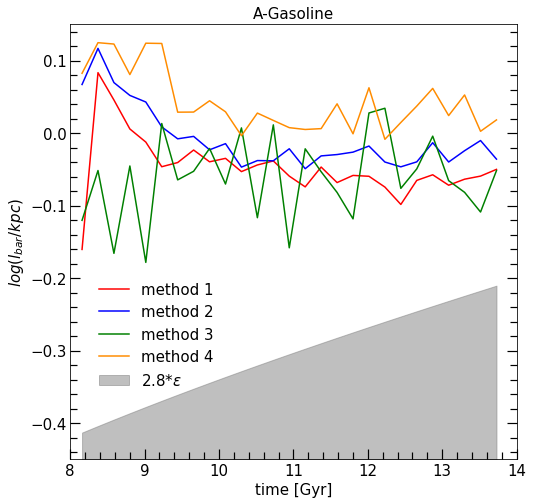

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(time_M31gs,np.log10(lbar1_M31gs), color='r', ls='-', label = 'method 1')#label='$L_{bar}$ at 0.15')
ax.plot(time_M31gs,np.log10(lbar3_M31gs), color='b', ls='-', label = 'method 2')#label='$L_{bar}$ at 0.25*$A_2^{max}$')
# ax.plot(time,np.log10(lbar2), color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.plot(time_M31gs,np.log10(lbar5_M31gs), color='g', ls='-', label = 'method 3')#label='$L_{bar}$ using $\phi(R)$',ls='-')
# ax.plot(time,np.log10(lbar4), color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.plot(time_M31gs,np.log10(lbar6_M31gs), color='darkorange', ls='-', label = 'method 4')#label='$L_{bar}$ using profiles x,y', ls='-')
ax.fill_between(time_M31gs,np.log10(eps_gs), -0.5, color='grey', alpha=0.5, label='2.8*$\epsilon$')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$log(l_{bar}/kpc)$',fontsize=15)
ax.set_xlabel('time [Gyr]',fontsize=15)
ax.set_ylim(-0.45,0.15)
ax.set_xlim(8,14)
# ax.set_yscale('log')
ax.legend(fontsize=15,frameon=False,loc=(0.05,0.15))
ax.set_title('A-Gasoline',fontsize=15)
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'lbar_time_allGS01.pdf', dpi = 100, xxbox_inches='tight')

In [3]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GS3_002.dat')
time_MWgs  = data[:,0]
lbar1_MWgs = data[:,1]
lbar2_MWgs = data[:,2]
lbar3_MWgs = data[:,3]
lbar4_MWgs = data[:,4]
lbar5_MWgs = data[:,5]
lbar6_MWgs = data[:,6]

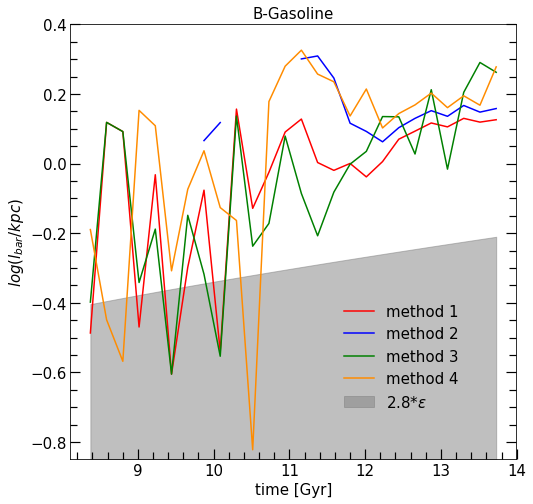

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(time_MWgs,np.log10(lbar1_MWgs), color='r', ls='-', label='method 1') # label='$L_{bar}$ at 0.15')
ax.plot(time_MWgs,np.log10(lbar3_MWgs), color='b', ls='-', label='method 2') # label='$L_{bar}$ at 0.25*$A_2^{max}$')
# ax.plot(time,np.log10(lbar2), color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.plot(time_MWgs,np.log10(lbar5_MWgs), color='g', ls='-', label='method 3') # label='$L_{bar}$ using $\phi(R)$',ls='-')
# ax.plot(time,np.log10(lbar4), color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.plot(time_MWgs,np.log10(lbar6_MWgs), color='darkorange',ls='-', label='method 4') # label='$L_{bar}$ using profiles x,y', ls='-')
ax.fill_between(time_MWgs,np.log10(eps_gs[:-1]), -0.9, color='grey',alpha=0.5, label='2.8*$\epsilon$')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$log(l_{bar}/kpc)$',fontsize=15)
ax.set_xlabel('time [Gyr]',fontsize=15)
ax.set_ylim(-0.85,0.4)
# ax.set_yscale('log')
ax.legend(fontsize=15,frameon=False, loc=(0.6,0.1))
ax.set_title('B-Gasoline',fontsize=15)
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'lbar_time_allGS02.pdf', dpi = 100, xxbox_inches='tight')

In [11]:
import pandas as pd
df1 = pd.DataFrame({'lbar1_M31gd': lbar1_M31gd[::-1]})
df2 = pd.DataFrame({'lbar6_M31gd': lbar6_M31gd[::-1]})
df3 = pd.DataFrame({'lbar1_M31gs': lbar1_M31gs[::-1]})
df4 = pd.DataFrame({'lbar6_M31gs': lbar6_M31gs[::-1]})
df5 = pd.DataFrame({'lbar1_MWgs': lbar1_MWgs[::-1]})
df6 = pd.DataFrame({'lbar6_MWgs': lbar6_MWgs[::-1]})

In [12]:
prueba1=df1.rolling(10, win_type='boxcar').mean()
prueba2=df2.rolling(10, win_type='boxcar').mean()
prueba3=df3.rolling(2, win_type='boxcar').mean()
prueba4=df4.rolling(2, win_type='boxcar').mean()
prueba5=df5.rolling(2, win_type='boxcar').mean()
prueba6=df6.rolling(2, win_type='boxcar').mean()

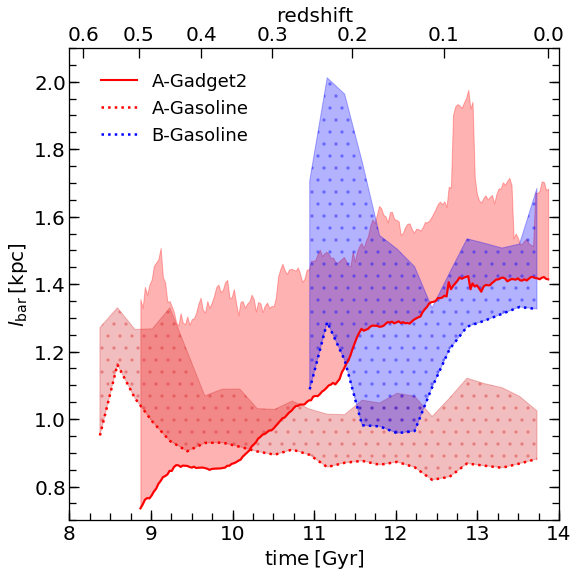

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)


# ax.plot(time_M31gd ,lbar1_M31gd,'-', lw=2.1, color='r', label='A-Gadget2')
# ax.plot(time_M31gd ,lbar6_M31gd,'-', lw=1.6, color='r', alpha=0.7)
# ax.plot(time_M31gs ,lbar1_M31gs,':', lw=2.5, color='r', label='A-Gasoline')
# ax.plot(time_M31gs ,lbar6_M31gs,':', lw=2., color='r', alpha=0.7)
# ax.plot(time_MWgs[:15] ,lbar1_MWgs[:15],  ':', lw=2.5, color='b', label='B-Gasoline')
# ax.plot(time_MWgs[:15] ,lbar6_MWgs[:15],  ':', lw=2., color='b',alpha=0.7)
ax.plot(time_M31gd[::-1] ,prueba1['lbar1_M31gd'],'-', lw=2.1, color='r', label='A-Gadget2')
# ax.plot(time_M31gd[::-1] ,prueba2['lbar6_M31gd'],'-', lw=1.6, color='r', alpha=0.7)
ax.plot(time_M31gs[::-1] ,prueba3['lbar1_M31gs'],':', lw=2.5, color='r', label='A-Gasoline')
# ax.plot(time_M31gs[::-1] ,prueba4['lbar6_M31gs'],':', lw=2., color='r', alpha=0.7)
ax.plot(time_MWgs[::-1][12:], prueba5['lbar1_MWgs'][12:],  ':', lw=2.5, color='b', label='B-Gasoline')
# ax.plot(time_MWgs[::-1][14:], prueba6['lbar6_MWgs'][14:],  ':', lw=2., color='b',alpha=0.7)

# ax.fill_between(time_M31gd,lbar1_M31gd,lbar6_M31gd,color='r',alpha=0.3)
# ax.fill_between(time_M31gs,lbar1_M31gs,lbar6_M31gs,color='tab:red',alpha=0.4)
# ax.fill_between(time_MWgs[:15],lbar1_MWgs[:15],lbar6_MWgs[:15],color='b',alpha=0.3)
ax.fill_between(time_M31gd[::-1],prueba1['lbar1_M31gd'],prueba2['lbar6_M31gd'],color='r',alpha=0.3)
ax.fill_between(time_M31gs[::-1],prueba3['lbar1_M31gs'],prueba4['lbar6_M31gs'],color='tab:red',alpha=0.3, hatch='.')
ax.fill_between(time_MWgs[::-1][12:], prueba5['lbar1_MWgs'][12:], prueba6['lbar6_MWgs'][12:],color='b',alpha=0.3,hatch='.')
ax.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=20)
ax.set_ylabel('$l_{\mathrm{bar}}\:[\mathrm{kpc}]$', fontsize=20)
ax.set_xticks([8,9,10,11,12,13,14])
# ax.set_yticks([0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1])
ax.set_ylim(0.7,2.1)
ax.set_xlim(8,14)
# ax.set_yscale('log')
ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
ax.yaxis.set_minor_locator(MultipleLocator(1/20.)) 
ax.legend(fontsize=18,frameon=False, loc=(0.05,0.78))
# ax[0,0].fill_between([7,15],0,0.14, facecolor='k', alpha=0.2, color='k') #, hatch='\\'

ax2 = ax.twiny()
new_tick_label = np.array([0.6,0.5,0.4,0.3,0.2,0.1,0])
ticks_pos = tiempo.conv(new_tick_label, h, omega_lambda, omega_matter)
# print ticks_pos
ax2.set_xticks(ticks_pos)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(new_tick_label)
# ax2.set_yscale('log')
ax2.set_xlabel('redshift',fontsize=20)
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax2.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)


path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'lbar_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

### Lbar GADGET a z=0

In [14]:
import numpy as np
# path = '/home/omarioni/'
path = '/home/ornela/PYTHON/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_A2phivsR_new.dat')
rn_M31gd  = M31_gd[:,0]
A2_M31gd  = M31_gd[:,1]
phi_M31gd = M31_gd[:,2]

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_A2phivsR_new.dat')
rn_MWgd  = MW_gd[:,0]
A2_MWgd  = MW_gd[:,1]
phi_MWgd = MW_gd[:,2]

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_A2phivsR_new.dat')
rn_M33gd  = M33_gd[:,0]
A2_M33gd  = M33_gd[:,1]
phi_M33gd = M33_gd[:,2]


M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_A2phivsR_new.dat')
rn_M31gs  = M31_gs[:,0]
A2_M31gs  = M31_gs[:,1]
phi_M31gs = M31_gs[:,2]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_A2phivsR_new.dat')
rn_MWgs  = MW_gs[:,0]
A2_MWgs  = MW_gs[:,1]
phi_MWgs = MW_gs[:,2]

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_A2phivsR_new.dat')
rn_M33gs  = M33_gs[:,0]
A2_M33gs  = M33_gs[:,1]
phi_M33gs = M33_gs[:,2]

In [15]:
phimed_M31gd = 0.8720655918121338
phimed_MWgd = -0.9769277095794677
phimed_M33gd =  0.05693308264017105

phimed_M31gs = 0.0028417275287210943
phimed_MWgs = -0.9361826181411743
phimed_M33gs = 0.17481132596731186

In [16]:
hbar1_M31gd = 0.10413574743811949
hbar1_MWgd = 0.028361310974868777
hbar1_M33gd = 0.016580518055631262

hbar1_M31gs = 0.10617148650113588
hbar1_MWgs = 0.11723678151284915
hbar1_M33gs = 0.018838115013791453

In [46]:
type(outer[0])

matplotlib.gridspec.SubplotSpec

In [17]:
angulo2 = 0.035
angulo = 0.3

line1 = + np.arcsin(angulo)
line2 = - np.arcsin(angulo)

line1_ = + np.arcsin(angulo2)
line2_ = - np.arcsin(angulo2)

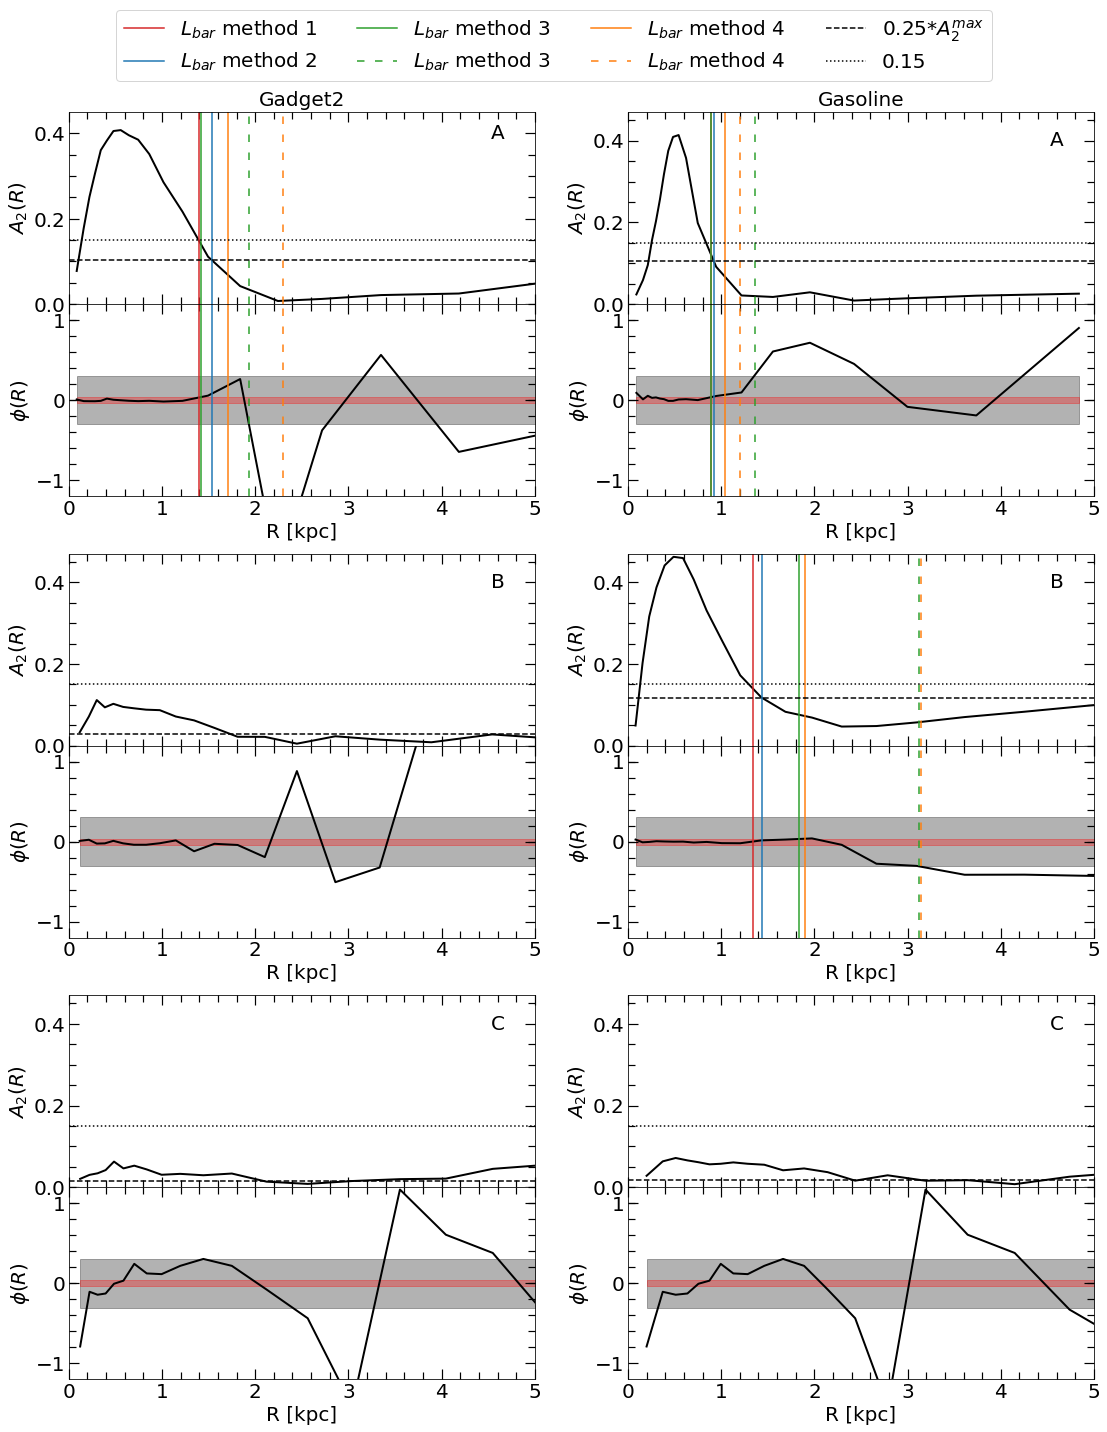

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(16,24), sharex=True,
#                        gridspec_kw = {'height_ratios':[4,2,4,2,4,2]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

fig = plt.figure(figsize=(16, 20))
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.15)
fig.subplots_adjust(bottom=0.04, left =0.08, right = 0.97, top = 0.92)

inner0 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[0], wspace=0., hspace=0.)
ax00 = plt.Subplot(fig, inner0[0])
ax00.plot(rn_M31gd,A2_M31gd, '-k', lw=2)
ax00.axvline(x=lbar1_M31gd[0], color='tab:red',   label='$L_{bar}$ method 1')
ax00.axvline(x=lbar3_M31gd[0], color='tab:blue',  label='$L_{bar}$ method 2')
ax00.axvline(x=lbar5_M31gd[0], color='tab:green', label='$L_{bar}$ method 3')
ax00.axvline(x=lbar2_M31gd[0], color='tab:green', label='$L_{bar}$ method 3', ls=(0,(5,7)))
ax00.axvline(x=lbar6_M31gd[0], color='tab:orange',label='$L_{bar}$ method 4')
ax00.axvline(x=lbar4_M31gd[0], color='tab:orange',label='$L_{bar}$ method 4',  ls=(0,(5,7)))
ax00.axhline(y=hbar1_M31gd,color='k',ls='--',label='0.25*$A_2^{max}$')
ax00.axhline(y=0.15,color='k',ls=':',label='0.15')
ax00.minorticks_on()
ax00.tick_params( labelsize=20)
ax00.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax00.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax00.set_ylabel('$A_{2}(R)$',fontsize=20)
ax00.set_xlim(0,5)
ax00.set_ylim(0,0.45)
ax00.set_xticklabels([])
ax00.set_title('Gadget2', fontsize=20)
ax00.text(4.6, 0.4,'A', fontsize=20, color='k', ha='center', va='center') 
fig.add_subplot(ax00)

ax01 = plt.Subplot(fig, inner0[1])
ax01.plot(rn_M31gd, phi_M31gd, '-k', lw=2)
ax01.fill_between(rn_M31gd,line2,line1,color='k',alpha=0.3)
ax01.fill_between(rn_M31gd,line2_,line1_,color='red',alpha=0.3)
ax01.axvline(x=lbar1_M31gd[0], color='tab:red')
ax01.axvline(x=lbar3_M31gd[0], color='tab:blue')
ax01.axvline(x=lbar2_M31gd[0], color='tab:green', ls=(0,(5,7)))
ax01.axvline(x=lbar5_M31gd[0], color='tab:green')
ax01.axvline(x=lbar4_M31gd[0], color='tab:orange', ls=(0,(5,7)))
ax01.axvline(x=lbar6_M31gd[0], color='tab:orange')
ax01.minorticks_on()
ax01.tick_params( labelsize=20)
ax01.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax01.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax01.set_ylabel('$\phi(R)$',fontsize=20)
ax01.set_xlabel('R [kpc]',fontsize=20)
ax01.set_ylim(-1.2,1.2)
ax01.set_xlim(0,5)
fig.add_subplot(ax01)


inner2 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[2], wspace=0., hspace=0.)
ax20 = plt.Subplot(fig, inner2[0])
ax20.plot(rn_MWgd,A2_MWgd, '-k' , lw=2)
ax20.axhline(y=hbar1_MWgd,color='k',ls='--')
ax20.axhline(y=0.15,color='k',ls=':')
ax20.minorticks_on()
ax20.tick_params( labelsize=20)
ax20.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax20.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax20.set_ylabel('$A_{2}(R)$',fontsize=20)
ax20.set_xlim(0,5)
ax20.set_ylim(0,0.47)
ax20.set_xticklabels([])
ax20.text(4.6, 0.4,'B', fontsize=20, color='k', ha='center', va='center') 
fig.add_subplot(ax20)

ax21 = plt.Subplot(fig, inner2[1])
ax21.plot(rn_MWgd, phi_MWgd, '-k', lw=2)
ax21.fill_between(rn_MWgd,line2,line1,color='k',alpha=0.3)
ax21.fill_between(rn_MWgd,line2_,line1_,color='red',alpha=0.3)
ax21.minorticks_on()
ax21.tick_params( labelsize=20)
ax21.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax21.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax21.set_ylabel('$\phi(R)$',fontsize=20)
ax21.set_xlabel('R [kpc]',fontsize=20)
ax21.set_ylim(-1.2,1.2)
ax21.set_xlim(0,5)
fig.add_subplot(ax21)


inner4 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[4], wspace=0., hspace=0.)
ax40 = plt.Subplot(fig, inner4[0])
ax40.plot(rn_M33gd,A2_M33gd, '-k', lw=2)
ax40.axhline(y=hbar1_M33gd,color='k',ls='--')
ax40.axhline(y=0.15,color='k',ls=':')
ax40.minorticks_on()
ax40.tick_params( labelsize=20)
ax40.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax40.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax40.set_ylabel('$A_{2}(R)$',fontsize=20)
ax40.set_xlim(0,5)
ax40.set_ylim(0,0.47)
ax40.set_xticklabels([])
ax40.text(4.6, 0.4,'C', fontsize=20, color='k', ha='center', va='center') 
fig.add_subplot(ax40)

ax41 = plt.Subplot(fig, inner4[1])
ax41.plot(rn_M33gd, phi_M33gd, '-k', lw=2)
ax41.fill_between(rn_M33gd,line2,line1,color='k',alpha=0.3)
ax41.fill_between(rn_M33gd,line2_,line1_,color='red',alpha=0.3)
ax41.minorticks_on()
ax41.tick_params( labelsize=20)
ax41.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax41.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax41.set_xlabel('R [kpc]',fontsize=20)
ax41.set_ylabel('$\phi(R)$',fontsize=20)
ax41.set_ylim(-1.2,1.2)
ax41.set_xlim(0,5)
fig.add_subplot(ax41)

inner1 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[1], wspace=0., hspace=0.)
ax10 = plt.Subplot(fig, inner1[0])
ax10.plot(rn_M31gs,A2_M31gs, '-k', lw=2)
ax10.axvline(x=lbar1_M31gs[0], color='tab:red')
ax10.axvline(x=lbar3_M31gs[0], color='tab:blue')
ax10.axvline(x=lbar5_M31gs[0], color='tab:green')
ax10.axvline(x=lbar2_M31gs[0], color='tab:green', ls=(0,(5,7)))
ax10.axvline(x=lbar6_M31gs[0], color='tab:orange')
ax10.axvline(x=lbar4_M31gs[0], color='tab:orange',  ls=(0,(5,7)))
ax10.axhline(y=hbar1_M31gs,color='k',ls='--')
ax10.axhline(y=0.15,color='k',ls=':')
ax10.minorticks_on()
ax10.tick_params( labelsize=20)
ax10.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax10.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax10.set_xlim(0,5)
ax10.set_ylim(0,0.47)
ax10.set_ylabel('$A_{2}(R)$',fontsize=20)
ax10.text(4.6, 0.4,'A', fontsize=20, color='k', ha='center', va='center') 
ax10.set_title('Gasoline', fontsize=20)
ax10.set_xticklabels([])
fig.add_subplot(ax10)

ax11 = plt.Subplot(fig, inner1[1])
ax11.plot(rn_M31gs, phi_M31gs, '-k', lw=2)
ax11.fill_between(rn_M31gs,line2,line1,color='k',alpha=0.3)
ax11.fill_between(rn_M31gs,line2_,line1_,color='red',alpha=0.3)
ax11.axvline(x=lbar1_M31gs[0], color='tab:red')
ax11.axvline(x=lbar3_M31gs[0], color='tab:blue')
ax11.axvline(x=lbar2_M31gs[0], color='tab:green', ls=(0,(5,7)))
ax11.axvline(x=lbar5_M31gs[0], color='tab:green')
ax11.axvline(x=lbar4_M31gs[0], color='tab:orange', ls=(0,(5,7)))
ax11.axvline(x=lbar6_M31gs[0], color='tab:orange')
ax11.minorticks_on()
ax11.tick_params( labelsize=20)
ax11.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax11.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax11.set_xlabel('R [kpc]',fontsize=20)
ax11.set_ylabel('$\phi(R)$',fontsize=20)
ax11.set_ylim(-1.2,1.2)
ax11.set_xlim(0,5)
fig.add_subplot(ax11)

inner3 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[3], wspace=0., hspace=0.)
ax30 = plt.Subplot(fig, inner3[0])
ax30.plot(rn_MWgs,A2_MWgs, '-k', lw=2)
ax30.axvline(x=lbar1_MWgs[0], color='tab:red')
ax30.axvline(x=lbar3_MWgs[0], color='tab:blue')
ax30.axvline(x=lbar2_MWgs[0], color='tab:green', ls=(0,(5,7)))
ax30.axvline(x=lbar5_MWgs[0], color='tab:green')
ax30.axvline(x=lbar4_MWgs[0], color='tab:orange', ls=(0,(5,7)))
ax30.axvline(x=lbar6_MWgs[0], color='tab:orange')
ax30.axhline(y=hbar1_MWgs,color='k',ls='--')
ax30.axhline(y=0.15,color='k',ls=':')
ax30.minorticks_on()
ax30.tick_params( labelsize=20)
ax30.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax30.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax30.set_xlim(0,5)
ax30.set_ylim(0,0.47)
ax30.set_ylabel('$A_{2}(R)$',fontsize=20)
ax30.set_xticklabels([])
ax30.text(4.6, 0.4,'B', fontsize=20, color='k', ha='center', va='center') 
fig.add_subplot(ax30)

ax30 = plt.Subplot(fig, inner3[1])
ax30.plot(rn_MWgs, phi_MWgs, '-k', lw=2)
ax30.fill_between(rn_MWgs,line2,line1,color='k',alpha=0.3)
ax30.fill_between(rn_MWgs,line2_,line1_,color='red',alpha=0.3)
ax30.axvline(x=lbar1_MWgs[0], color='tab:red')
ax30.axvline(x=lbar3_MWgs[0], color='tab:blue')
ax30.axvline(x=lbar2_MWgs[0], color='tab:green', ls=(0,(5,7)))
ax30.axvline(x=lbar5_MWgs[0], color='tab:green')
ax30.axvline(x=lbar4_MWgs[0], color='tab:orange', ls=(0,(5,7)))
ax30.axvline(x=lbar6_MWgs[0], color='tab:orange')
ax30.minorticks_on()
ax30.tick_params( labelsize=20)
ax30.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax30.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax30.set_xlabel('R [kpc]',fontsize=20)
ax30.set_ylabel('$\phi(R)$',fontsize=20)
ax30.set_xlim(0,5)
ax30.set_ylim(-1.2,1.2)
fig.add_subplot(ax30)


inner5 = gridspec.GridSpecFromSubplotSpec(2, 1,
                 subplot_spec=outer[5], wspace=0., hspace=0.)
ax50 = plt.Subplot(fig, inner5[0])
ax50.plot(rn_M33gs,A2_M33gs, '-k', lw=2)
ax50.axhline(y=hbar1_M33gs,color='k',ls='--')
ax50.axhline(y=0.15,color='k',ls=':')
ax50.minorticks_on()
ax50.tick_params( labelsize=20)
ax50.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax50.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax50.set_xlim(0,5)
ax50.set_ylim(0,0.47)
ax50.set_xticklabels([])
ax50.set_ylabel('$A_{2}(R)$',fontsize=20)
ax50.text(4.6, 0.4,'C', fontsize=20, color='k', ha='center', va='center') 
fig.add_subplot(ax50)

ax51 = plt.Subplot(fig, inner5[1])
ax51.plot(rn_M33gs, phi_M33gd, '-k', lw=2)
ax51.fill_between(rn_M33gs,line2,line1,color='k',alpha=0.3)
ax51.fill_between(rn_M33gs,line2_,line1_,color='red',alpha=0.3)
ax51.minorticks_on()
ax51.tick_params( labelsize=20)
ax51.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax51.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax51.set_xlabel('R [kpc]',fontsize=20)
ax51.set_ylabel('$\phi(R)$',fontsize=20)
ax51.set_ylim(-1.2,1.2)
ax51.set_xlim(0,5)
fig.add_subplot(ax51)

fig.legend(fontsize=20, loc='upper center', ncol=4)
plt.show()
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'A2phi_vsR.pdf', dpi = 100, xxbox_inches='tight')



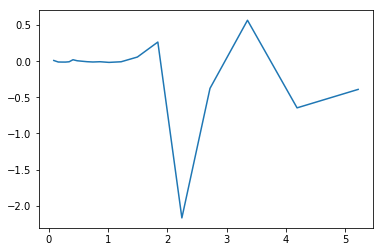

In [53]:
plt.plot(rn_M31gd, phi_M31gd)

/home/omarioni/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


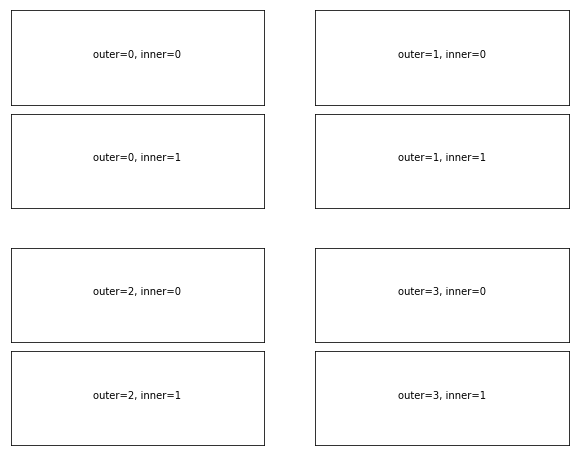

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

In [11]:
import numpy as np
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'


M31GD = np.loadtxt(path + 'M31GD_xysurfden_profile.dat')
medx_M31GD = M31GD[:,0]
medy_M31GD = M31GD[:,1]
sigx_M31GD = M31GD[:,2]
sigy_M31GD = M31GD[:,3]

M31GD = np.loadtxt(path + 'M31GD_Rsurfden_profile.dat')
R_M31GD = M31GD[:,0]
Rp_M31GD = M31GD[:,1]

M31GD = np.loadtxt(path + 'M31GD_diffsurfden_profile.dat')
difR_M31GD = M31GD[:,0]
diff_M31GD = M31GD[:,1]


MWGD = np.loadtxt(path + 'MWGD_xysurfden_profile.dat')
medx_MWGD = MWGD[:,0]
medy_MWGD = MWGD[:,1]
sigx_MWGD = MWGD[:,2]
sigy_MWGD = MWGD[:,3]

MWGD = np.loadtxt(path + 'MWGD_Rsurfden_profile.dat')
R_MWGD = MWGD[:,0]
Rp_MWGD = MWGD[:,1]

MWGD = np.loadtxt(path + 'MWGD_diffsurfden_profile.dat')
difR_MWGD = MWGD[:,0]
diff_MWGD = MWGD[:,1]


M33GD = np.loadtxt(path + 'M33GD_xysurfden_profile.dat')
medx_M33GD = M33GD[:,0]
medy_M33GD = M33GD[:,1]
sigx_M33GD = M33GD[:,2]
sigy_M33GD = M33GD[:,3]

M33GD = np.loadtxt(path + 'M33GD_Rsurfden_profile.dat')
R_M33GD = M33GD[:,0]
Rp_M33GD = M33GD[:,1]

M33GD = np.loadtxt(path + 'M33GD_diffsurfden_profile.dat')
difR_M33GD = M33GD[:,0]
diff_M33GD = M33GD[:,1]

In [10]:
import numpy as np
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'

M31GS = np.loadtxt(path + 'M31GS_xysurfden_profile.dat')
medx_M31GS = M31GS[:,0]
medy_M31GS = M31GS[:,1]
sigx_M31GS = M31GS[:,2]
sigy_M31GS = M31GS[:,3]

M31GS = np.loadtxt(path + 'M31GS_Rsurfden_profile.dat')
R_M31GS = M31GS[:,0]
Rp_M31GS = M31GS[:,1]

M31GS = np.loadtxt(path + 'M31GS_diffsurfden_profile.dat')
difR_M31GS = M31GS[:,0]
diff_M31GS = M31GS[:,1]


MWGS = np.loadtxt(path + 'MWGS_xysurfden_profile.dat')
medx_MWGS = MWGS[:,0]
medy_MWGS = MWGS[:,1]
sigx_MWGS = MWGS[:,2]
sigy_MWGS = MWGS[:,3]

MWGS = np.loadtxt(path + 'MWGS_Rsurfden_profile.dat')
R_MWGS = MWGS[:,0]
Rp_MWGS = MWGS[:,1]

MWGS = np.loadtxt(path + 'MWGS_diffsurfden_profile.dat')
difR_MWGS = MWGS[:,0]
diff_MWGS = MWGS[:,1]


M33GS = np.loadtxt(path + 'M33GS_xysurfden_profile.dat')
medx_M33GS = M33GS[:,0]
medy_M33GS = M33GS[:,1]
sigx_M33GS = M33GS[:,2]
sigy_M33GS = M33GS[:,3]

M33GS = np.loadtxt(path + 'M33GS_Rsurfden_profile.dat')
R_M33GS = M33GS[:,0]
Rp_M33GS = M33GS[:,1]

M33GS = np.loadtxt(path + 'M33GS_diffsurfden_profile.dat')
difR_M33GS = M33GS[:,0]
diff_M33GS = M33GS[:,1]

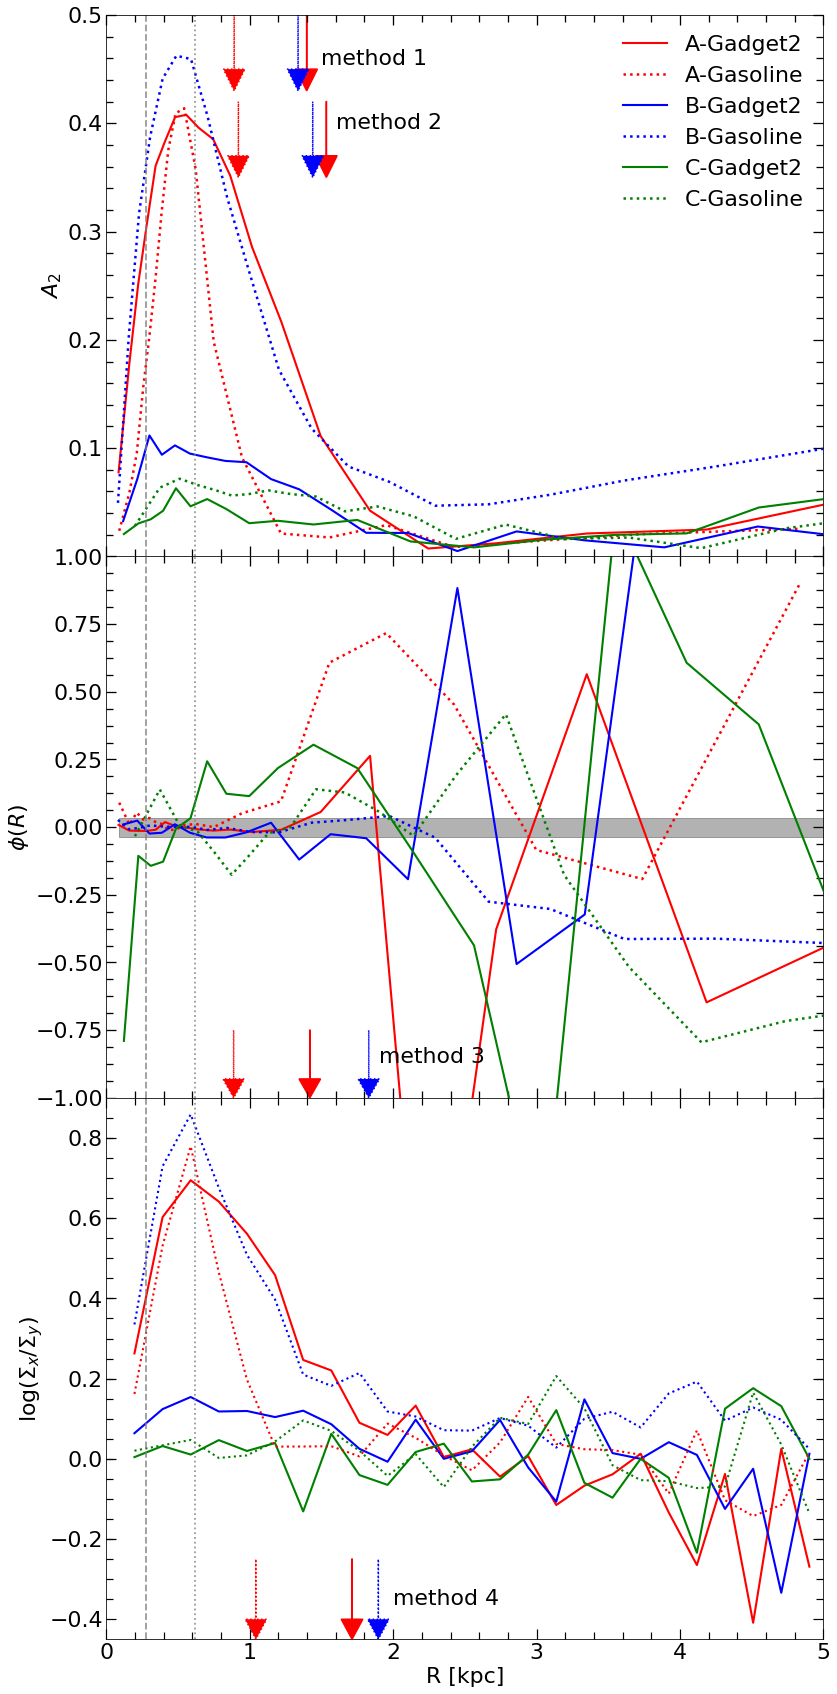

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,24), sharex=True)
fig.subplots_adjust(bottom=0.04, left =0.12, right = 0.95, top = 0.98, wspace=0., hspace= 0.0)

ax[0].plot(rn_M31gd,A2_M31gd,'-', lw=2.1, color='r', label='A-Gadget2')
ax[0].plot(rn_M31gs,A2_M31gs,':', lw=2.5, color='r', label='A-Gasoline')
ax[0].plot(rn_MWgd, A2_MWgd, '-', lw=2.1, color='b', label='B-Gadget2')
ax[0].plot(rn_MWgs ,A2_MWgs, ':', lw=2.5, color='b', label='B-Gasoline')
ax[0].plot(rn_M33gd,A2_M33gd,'-', lw=2.1, color='g', label='C-Gadget2')
ax[0].plot(rn_M33gs,A2_M33gs,':', lw=2.5, color='g', label='C-Gasoline')
ax[0].set_ylabel(r'$A_{\mathrm{2}}$', fontsize=22, fontname='Times')
ax[0].axvline(x=eps_gd[0], ls='--',color='grey',alpha=0.8,lw=1.8)
ax[0].axvline(x=eps_gs[0], ls=':',color='grey',alpha=0.8,lw=1.8)
# ax[0].set_xlabel(u'$R\:\mathrm{[kpc]}$', fontsize=22)
ax[0].set_yticks([0.1,0.2,0.3,0.4,0.5])
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_ylim(0,0.5)
ax[0].set_xlim(0,5)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=22)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True, top=True)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True, top=True)

ax[0].arrow(x=lbar1_M31gd[0], y=0.5, dx=0, dy=-0.07, color='r', lw=1.5,
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].arrow(x=lbar1_M31gs[0], y=0.5, dx=0, dy=-0.07, color='r', lw=1.5, ls=':',
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].arrow(x=lbar1_MWgs[0], y=0.5, dx=0, dy=-0.07, color='b', lw=1.5, ls=':',
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].text(1.5,0.46,'method 1',fontsize=22, color='k',ha='left',va='center')


ax[0].arrow(x=lbar3_M31gd[0], y=0.42, dx=0, dy=-0.07, color='r', lw=1.5,
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].arrow(x=lbar3_M31gs[0], y=0.42, dx=0, dy=-0.07, color='r', lw=1.5, ls=':',
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].arrow(x=lbar3_MWgs[0], y=0.42, dx=0, dy=-0.07, color='b', lw=1.5, ls=':',
         head_length=0.02, head_width=0.15, length_includes_head=True)
ax[0].text(1.6,0.4,'method 2',fontsize=22, color='k',ha='left',va='center')

ax[0].legend(fontsize=22,frameon=False, loc=1)


ax[1].plot(rn_M31gd,phi_M31gd,'-', lw=2.1, color='r', label='A-Gadget2')
ax[1].plot(rn_M31gs,phi_M31gs,':', lw=2.5, color='r', label='A-Gasoline')
ax[1].plot(rn_MWgd, phi_MWgd, '-', lw=2.1, color='b', label='B-Gadget2')
ax[1].plot(rn_MWgs ,phi_MWgs, ':', lw=2.5, color='b', label='B-Gasoline')
ax[1].plot(rn_M33gd,phi_M33gd,'-', lw=2.1, color='g', label='C-Gadget2')
ax[1].plot(rn_M33gs,phi_M33gs,':', lw=2.5, color='g', label='C-Gasoline')
ax[1].fill_between(rn_M31gd,line2_,line1_,color='k',alpha=0.3)
ax[1].axvline(x=eps_gd[0], ls='--',color='grey',alpha=0.8,lw=1.8)
ax[1].axvline(x=eps_gs[0], ls=':',color='grey',alpha=0.8,lw=1.8)
ax[1].set_ylabel(r'$\phi(R)$', fontsize=22)
# ax[1].set_xlabel(u'$R\:\mathrm{[kpc]}$', fontsize=20)
ax[1].set_ylim(-1.0,1.0)
ax[1].set_xlim(0,5)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=22)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True, top=True)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True, top=True)

ax[1].arrow(x=lbar5_M31gd[0], y=-0.75, dx=0, dy=-0.25, color='r', lw=1.5,
         head_length=0.07, head_width=0.15, length_includes_head=True)
ax[1].arrow(x=lbar5_M31gs[0], y=-0.75, dx=0, dy=-0.25, color='r', lw=1.5, ls=':',
         head_length=0.07, head_width=0.15, length_includes_head=True)
ax[1].arrow(x=lbar5_MWgs[0], y=-0.75, dx=0, dy=-0.25, color='b', lw=1.5, ls=':',
         head_length=0.07, head_width=0.15, length_includes_head=True)
ax[1].text(1.9,-0.85,'method 3',fontsize=22, color='k',ha='left',va='center')


ax[2].plot(difR_M31GD, diff_M31GD, '-r', lw = 2.1, label='A-Gadget2')
ax[2].plot(difR_MWGD, diff_MWGD, '-b', lw = 2.1, label='B-Gadget2')
ax[2].plot(difR_M33GD, diff_M33GD, '-g', lw = 2.1, label='C-Gadget2')
ax[2].plot(difR_M31GS, diff_M31GS, ':r', lw = 2.1, label='A')
ax[2].plot(difR_MWGS, diff_MWGS, ':b', lw = 2.1, label='B')
ax[2].plot(difR_M33GS, diff_M33GS, ':g', lw = 2.1, label='C')
ax[2].axvline(x=eps_gd[0], ls='--',color='grey',alpha=0.8,lw=1.8)
ax[2].axvline(x=eps_gs[0], ls=':',color='grey',alpha=0.8,lw=1.8)
# ax[0].axvline(x=lbar6_M31GD,ls='-',ymin=0., ymax=0.2,color='r', lw=1.5)
ax[2].arrow(x=lbar6_M31gd[0],y=-0.25,dx=0,dy=-0.2,color='r', lw=1.5,
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[2].arrow(x=lbar6_M31gs[0],y=-0.25,dx=0,dy=-0.2,color='r', lw=1.5, ls=':',
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[2].arrow(x=lbar6_MWgs[0],y=-0.25,dx=0,dy=-0.2,color='b', lw=1.5, ls=':',
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[2].text(2,-0.35,'method 4',fontsize=22, color='k',ha='left',va='center')
ax[2].minorticks_on()
ax[2].set_ylim(-0.45,0.9)
ax[2].tick_params( labelsize=22)
ax[2].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[2].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[2].set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=22)
ax[2].set_xlabel('R [kpc]',fontsize=22)


plt.show()
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'A2phi_vsR_v2.pdf', dpi = 100, xxbox_inches='tight')



In [4]:
print(lbar1_M31gd[0])
print(lbar1_M31gs[0])
print(lbar1_MWgs[0])

1.39687181
0.89127194
1.33678655


In [5]:
print(lbar3_M31gd[0])
print(lbar3_M31gs[0])
print(lbar3_MWgs[0])

1.53419664
0.9207877
1.43931323


In [6]:
print(lbar5_M31gd[0])
print(lbar5_M31gs[0])
print(lbar5_MWgs[0])

1.41884378
0.88777007
1.82991487


In [7]:
print(lbar6_M31gd[0])
print(lbar6_M31gs[0])
print(lbar6_MWgs[0])

1.71311432
1.04292214
1.89647541


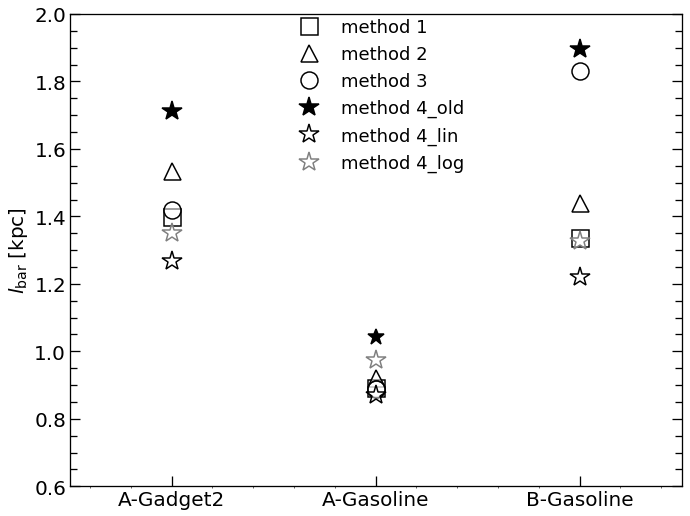

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as color

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(0,2.5,'s', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='method 1')
ax.plot(0,2.5,'^', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='method 2')
ax.plot(0,2.5,'o', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='method 3')
ax.plot(0,2.5,'*', mec='k', mfc='k', ms=20, mew=1.5, label='method 4_old')
ax.plot(0,2.5,'*', mec='k', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5, label='method 4_lin')
ax.plot(0,2.5,'*', mec='gray', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5, label='method 4_log')

ax.plot(0,lbar1_M31gd[0],'s', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(0,lbar3_M31gd[0],'^', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(0,lbar5_M31gd[0],'o', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(0,lbar6_M31gd[0],'*', mec='k', mfc='k', ms=20, mew=1.5)
ax.plot(0,1.2678,'*', mec='k', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)
ax.plot(0,1.35065,'*', mec='gray', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)

ax.plot(1,lbar1_M31gs[0],'s', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(1,lbar3_M31gs[0],'^', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(1,lbar5_M31gs[0],'o', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(1,lbar5_M31gs[0],'o', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(1,lbar6_M31gs[0],'*', mec='k', mfc='k', ms=17, mew=1.5)
ax.plot(1,0.8717,'*', mec='k', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)
ax.plot(1,0.9735,'*', mec='gray', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)

ax.plot(2,lbar1_MWgs[0],'s', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(2,lbar3_MWgs[0],'^', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(2,lbar5_MWgs[0],'o', mec='k', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5)
ax.plot(2,lbar6_MWgs[0],'*', mec='k', mfc='k', ms=20, mew=1.5)
ax.plot(2,1.22035,'*', mec='k', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)
ax.plot(2,1.3285,'*', mec='gray', mfc=color.to_rgba('w',0.5), ms=20, mew=1.5)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0.6,2)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['A-Gadget2','A-Gasoline','B-Gasoline'])
ax.set_ylabel(r'$l_{\mathrm{bar}}$ [kpc]',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('y', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax.legend(fontsize=18,frameon=False, loc=(0.35,0.65))

plt.show()

| A-GADGET2 |    | A-GASOLINE |    | B-GASOLINE |    |
| :-------: |:--:| :--------: |:--:| :--------: |:--:|
| LIN | LOG | LIN | LOG | LIN | LOG |
|1,2824 |1,3617 |0,9181 |0,9624 |1,2559  |1,3396 |
|1,2532 |1,3396 |0,8253 |0,9846 |1,1848  |1,3174 |
|1,2678 |1,35065|0,8717 |0,9735 |1,22035 |1,3285 |

In [123]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4]})
df


,B
0,0
1,1
2,2
3,3
4,4


In [131]:
df.rolling(3, win_type='boxcar').mean()

,B
0,NaN
1,NaN
2,1.0
3,2.0
4,3.0


In [130]:
df.rolling(3, win_type='boxcar').sum()

,B
0,NaN
1,NaN
2,3.0
3,6.0
4,9.0
